In [19]:
import pandas as pd 
import sqlite3
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


conn = sqlite3.connect("../data/sales.db")


query = '''
    WITH CustMetrics AS (
        SELECT
            c.customer_id,
            c.country,
            o.order_date,
            --1. RECENCY:
            CAST(julianday('now') - julianday(MAX (o.order_date)) AS INTEGER) as order_recency,
            --2. MONETARY:
            SUM (o.order_amount) AS total_spent,
            --3. FREQUENCY:
            COUNT (o.order_id) AS order_count
        FROM orders o 
        JOIN customers c ON o.customer_id = c.customer_id
        GROUP BY c.customer_id
        ),
        RFM_score AS(
            SELECT *,
            NTILE(5) OVER (ORDER BY order_recency DESC) AS r_score,
            NTILE(5) OVER (ORDER BY order_count ASC) AS f_score,
            NTILE(5) OVER (ORDER BY total_spent ASC) AS m_score
            FROM CustMetrics
            )
    SELECT *,
        CASE
            WHEN r_score=5 AND m_score=5 AND f_score = 5 THEN 'Champion' 
            WHEN r_score >=4 AND m_score =5 AND f_score >=4 THEN 'Loyal'
            WHEN r_score=5 AND f_score = 1 THEN 'New Customer'
            WHEN r_score>=1 AND m_score >=2 AND f_score >=2 THEN 'At Risk'
            WHEN r_score>=1 AND m_score =5 AND f_score =5 THEN "Can't Lose"
            ELSE 'Standard'
        END AS customer_segment
    FROM  RFM_score
    '''
df_seg = pd.read_sql(query,conn)
conn.close()

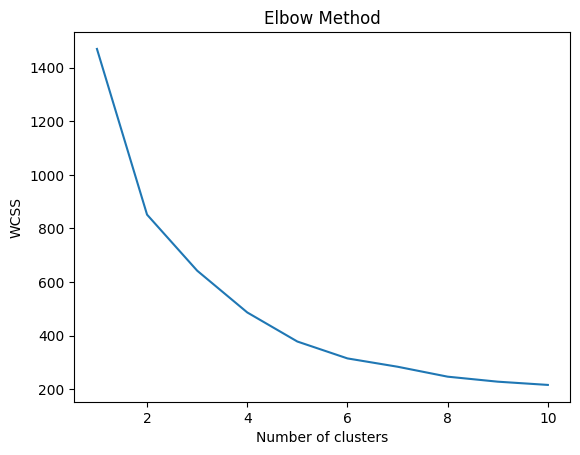

In [17]:

features = ['order_recency', 'order_count', 'total_spent']
x = df_seg[features]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(x_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


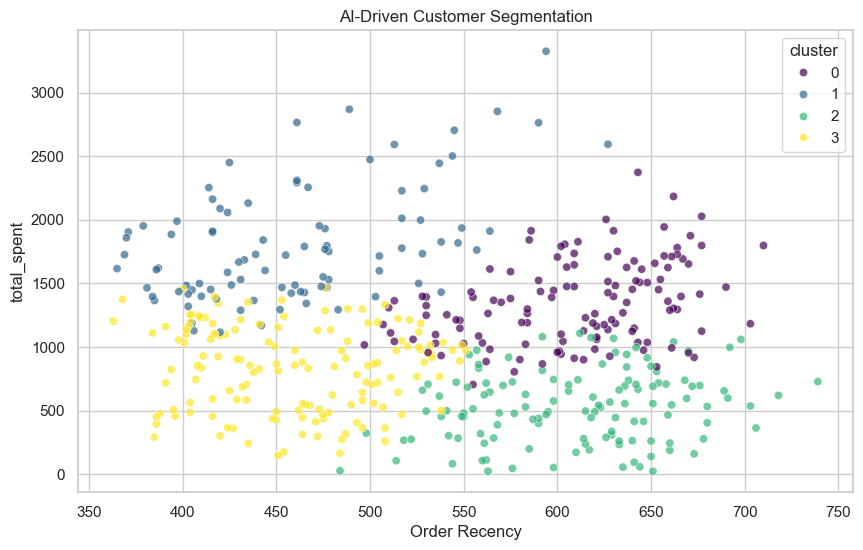

   cluster customer_segment  total_spent
0        0          At Risk  1345.882969
1        1          At Risk  1718.745556
2        1         Champion  1888.263889
3        1            Loyal  1965.306500
4        2          At Risk   801.258000
5        2         Standard   347.690533
6        3          At Risk  1005.290000
7        3     New Customer   420.358750
8        3         Standard   416.096286


In [23]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
df_seg['cluster'] = kmeans.fit_transform(x_scaled).argmin(axis=1)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_seg, x='order_recency', y='total_spent', hue='cluster', palette='viridis', alpha=0.7)
plt.title('AI-Driven Customer Segmentation')
plt.xlabel('Order Recency')
plt.show()
print(df_seg.groupby(['cluster', 'customer_segment']).agg({'total_spent': 'mean'}).reset_index())




